
 set|  max word-stroke length| avg strokes length | max drawing-stroke length
--|--|--|--
training set (0+1)|289|14|1046
validation set (2)|233| ?|618
test set (3) |218|?|423

trim data at 1050 which has a lot more divisors than 1046 so it's more convenient in regards to pooling

In [69]:
foo=np.arange(8)#used this in pahaw to reverse the measures

keepmeasures=np.array([1,0,2,3])

foo[keepmeasures]

array([1, 0, 2, 3])

In [1]:
#smart manuscript
from smartmanuscript.corpus_iam import _import_set

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})#for prettier plots
#math tools
import numpy as np
#preprocessing
from sklearn.preprocessing import scale
#machine learning
import torch
from sklearn.model_selection import StratifiedKFold
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("using",device,"device")
#io
from os.path import join
from os.path import exists
from os import makedirs
from os import listdir
import pickle
import sys
sys.path.append("..")
#utils
from time import time
import warnings
#custom
from parkinson_detection.modules.utils import *

using cuda device


# Utils

In [21]:
def plot(plot_i,train,valid,test):
    plt.title(model_name)
    plt.plot(train,label="training")
    if valid is not None:
        plt.plot(valid,label="validation")
    plt.plot(test,label="test")
    plt.xlabel("epochs")
    plt.ylabel(index2plot[plot_i])
    plt.legend()
    if plot_i!=0:
        plt.ylim(0,1)

def plot_measures(task,subplot=True,figsize=(16,12)):
    plt.figure(figsize=figsize)
    for i,measure in enumerate(index2measure):
        if subplot:
            plt.subplot(3,3,i+1)
        plt.plot(task[:,i])
        plt.xlabel("timesteps")
        plt.ylabel(measure)

# Data loading

In [91]:
set_numbers=[0,1,2,3,4]
set_number=set_numbers[3]
assert set_number in set_numbers
iamondo_path="data/IAMonDo-db-1.0"#join("data","IAMonDo-db-1.0")
max_len=1050
measure2index={"x-coordinate":0,"y-coordinate":1,"timestamp":2,"pressure":3}
index2measure=list(measure2index.keys())

In [94]:
def scale_and_pad(data,max_len):
    tmp=[]
    for stroke in data:
        stroke=scale(stroke,axis=0)
        if len(stroke) > max_len:
            stroke=stroke[:max_len]
        else:
            stroke=np.concatenate((stroke,np.zeros(shape=(max_len-len(stroke),stroke.shape[1]))))#zero-padding
        tmp.append(stroke)
    return np.asarray(tmp)

In [ ]:
if True:    
    if False:        
        words, lines,drawings = _import_set(iamondo_path, "{}.set".format(set_number), max_files=None)
        words=np.asarray([stroke for word in words for stroke in  word[1]])
        drawings=np.asarray([stroke for drawing in drawings for stroke in drawing])        
        np.save(join("data","words_{}.set.npy".format(set_number)),words)     
        np.save(join("data","drawings_{}.set.npy".format(set_number)),drawings)
    else:
        print("loading raw data")
        words=np.load(join("data","words_0_1.set.npy"))
        print("raw words shape",words.shape)
        drawings=np.load(join("data","drawings_0_1.set.npy"))
        print("raw drawings shape",drawings.shape)
    print("scaling and padding data at",max_len)
    words=scale_and_pad(words,max_len)
    drawings=scale_and_pad(drawings,max_len)
    print("words.shape",words.shape)
    print("drawings.shape",drawings.shape)
    np.save(join("data","padded_drawings_0_1.set.npy"),drawings)
    np.save(join("data","padded_words_0_1.set.npy"),words)
else:
    print("loading scaled and padded data")
    train_set=np.load(join("data","padded_0_1.set.npy"))
    test_set=np.load(join("data","padded_3.set.npy"))
    #reverse x and y column to match PaHaW
    train_set=train_set[:,:,::-1]
    test_set=test_set[:,:,::-1]
    print("train_set.shape",train_set.shape)
    print("test_set.shape",test_set.shape)

loading raw data
raw words shape (114564,)
raw drawings shape (24200,)
scaling and padding data at 1050


In [90]:
max([stroke.shape[0] for stroke in drawings])

423

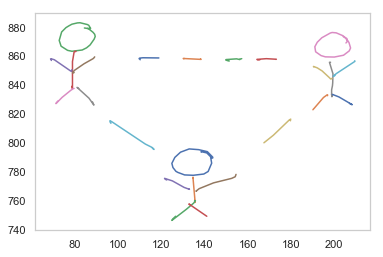

In [30]:
for j,i in enumerate(drawings[0]):
    plt.plot(i[:,0],i[:,1])

In [16]:
def plot_task(task,measure2index=measure2index):
    plt.plot(task[:,measure2index["x-coordinate"]],task[:,measure2index["y-coordinate"]])
    plt.xlabel("x-coordinate")
    plt.ylabel("y-coordinate")

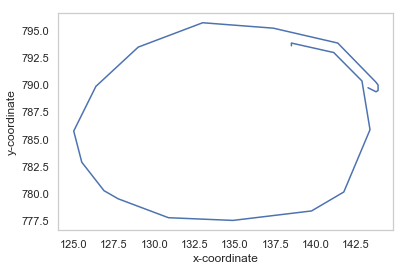

In [27]:
plot_task(drawings[0][0],measure2index)

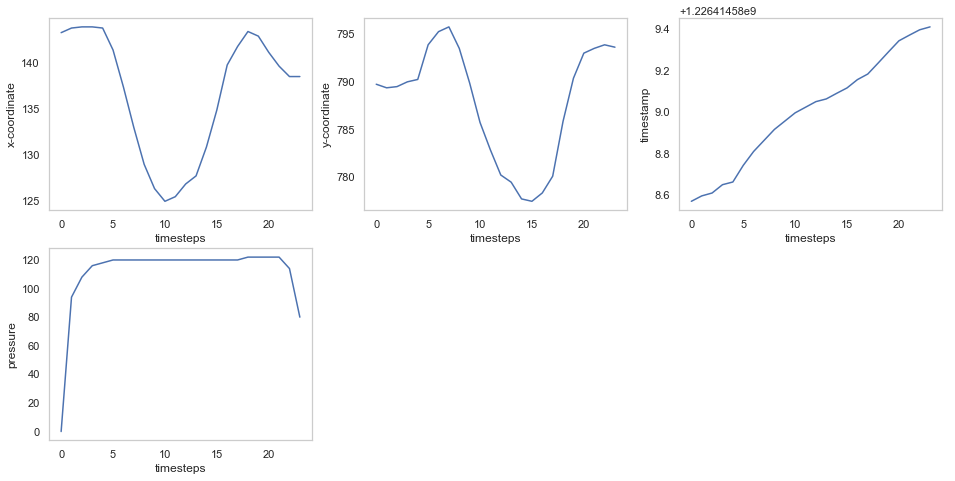

In [28]:
plot_measures(drawings[0][0])

import set: data/IAMonDo-db-1.0/2.set
 14320 words and 5347 textlines have been imported from 200 inkml-files 


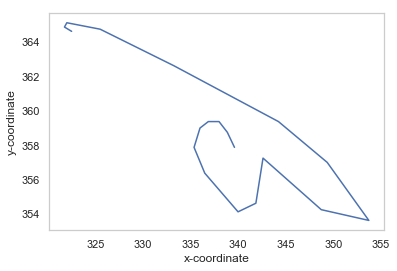

In [63]:
plot_task(drawings_np[-1],measure2index)

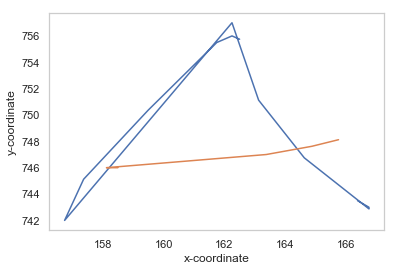

In [46]:
for s in words[0][1]:
    plot_task(s,measure2index)

#  Model

https://pytorch.org/docs/stable/nn.html#convtranspose1d

In [6]:
import torch

class CNNAutoencoder(torch.nn.Module):
    def __init__(self,input_size,hidden_size,conv_kernel,pool_kernel ,padding,
                 stride=1,dilation=1, dropout=0.0):
        super(CNNAutoencoder, self).__init__()
        self.num_layers=len(hidden_size) 
        
        layers=[]
        for i, (h,c,p,pad) in enumerate(list(zip(hidden_size,conv_kernel,pool_kernel,padding))):
            s = input_size if i ==0 else hidden_size[i-1]
            layers+=[
                torch.nn.Conv1d(s,h,c,stride=p,padding=pad,dilation=1),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout)
            ]
        self.encoder=torch.nn.Sequential(*layers)
        
        layers=[]
        for i, (h,c,p,pad) in enumerate(list(zip(hidden_size,conv_kernel,pool_kernel,padding))[::-1]):
            if i ==self.num_layers-1:                
                s= input_size
                layers+=[
                    torch.nn.ConvTranspose1d(h,s,c,stride=p,padding=pad,dilation=1)
                ]
            else :
                s = hidden_size[::-1][i+1]      
                layers+=[
                    torch.nn.ConvTranspose1d(h,s,c,stride=p,padding=pad,dilation=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(dropout)
                ]        
        self.decoder=torch.nn.Sequential(*layers)
        
    def forward(self,subject):
        code=self.encoder(subject)
        decode=self.decoder(code)        
        return decode#self.sigmoid(d_c1)


# Training def

In [7]:
def step(input, target, model, optimizer, loss_fn, batch_size,validation = False, device="cuda"):
    if not validation:
        # Zero gradients
        optimizer.zero_grad()

    # Set device options
    input=input.to(device)
    target=target.to(device)
    #forward pass
    output=model(input)

    # Compute loss
    loss = loss_fn(output, target)
    if not validation:
        # Perform backpropagation
        loss.backward()
        # Adjust model weights
        optimizer.step()
    return loss.item(), output.squeeze().cpu().detach().numpy()

#  Hyperparameters

In [114]:
288/16

18.0

In [115]:
18/8

2.25

In [14]:
dropout=0.0
hidden_size=[16,32,64]  
conv_kernel= [8,4,3]
pool_kernel=[8,4,3]
assert (max_len/np.prod(pool_kernel))%1==0
dilation= 'redef as 1'#[1,1]
stride='redef as kernel_size'
output_size="foo"
padding=[0,0,0]
"""for d,k in list(zip(dilation,conv_kernel)):
    padding.append((k-1)//2)#d*(k-1)//2)"""
input_size=2
batch_size=64
loss_fn=torch.nn.MSELoss()

learning_rate=1e-3
verbose=False
model_type="CNNAutoencoder"

model_name=str((model_type,learning_rate,hidden_size, dropout, conv_kernel,pool_kernel,dilation))

In [15]:
torch.manual_seed(1)
model=CNNAutoencoder(input_size,hidden_size,conv_kernel,pool_kernel ,padding,stride,dilation, dropout)

model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
print(count_params(model))
print(model)
start = time()
train_loss,test_loss=[],[]
for epoch in range(10):
    np.random.seed(1)
    np.random.shuffle(train_set)#shuffle train_set to facilitate SGD
    
    #training
    model.train()
    batch_loss=0
    for batch_i in range(0,len(train_set),batch_size):
        batch=torch.Tensor(train_set[batch_i:batch_i+batch_size].copy()).transpose(1,2)
        loss,output=step(batch, batch, model, optimizer, loss_fn, batch_size,False,device)
        batch_loss+=loss
    train_loss.append(batch_loss/(len(train_set)//batch_size))
    
    #testing
    model.eval()
    batch_loss=0
    for batch_i in range(0,len(test_set),batch_size):
        batch=torch.Tensor(test_set[batch_i:batch_i+batch_size].copy()).transpose(1,2)
        loss,output=step(batch, batch, model, optimizer, loss_fn, batch_size,True,device)
        batch_loss+=loss
    test_loss.append(batch_loss/(len(test_set)//batch_size))
    if verbose:
        print(epoch,train_loss[-1],test_loss[-1])

print("Done. Spent",timeSince(start))

(17058, 17058)
CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(2, 16, kernel_size=(8,), stride=(8,))
    (1): ReLU()
    (2): Dropout(p=0.0)
    (3): Conv1d(16, 32, kernel_size=(4,), stride=(4,))
    (4): ReLU()
    (5): Dropout(p=0.0)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(3,))
    (7): ReLU()
    (8): Dropout(p=0.0)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(3,))
    (1): ReLU()
    (2): Dropout(p=0.0)
    (3): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(4,))
    (4): ReLU()
    (5): Dropout(p=0.0)
    (6): ConvTranspose1d(16, 2, kernel_size=(8,), stride=(8,))
  )
)
Done. Spent 1m 31s


In [128]:
model.decoder[0]

ConvTranspose1d(64, 32, kernel_size=(6,), stride=(3,), padding=(2,))

In [ ]:
model.encoder(target).shape

In [92]:
directory = join("weights", model_name)
if not exists(directory):
    makedirs(directory)
torch.save({
    'epoch': epoch,
    'model': model.state_dict(),
    'opt': optimizer.state_dict(),
    'loss': test_loss[-1]
}, join(directory, '{}_checkpoint.tar'.format(epoch)))

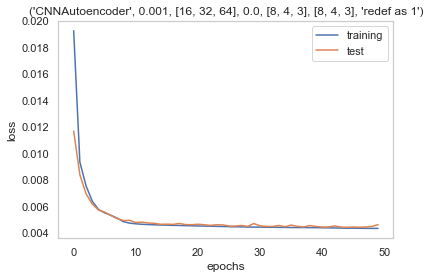

In [83]:
plot(0,train_loss,None,test_loss)

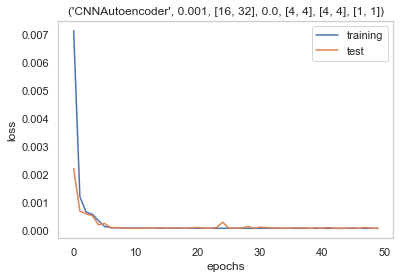

In [42]:
plot(0,train_loss,None,test_loss)

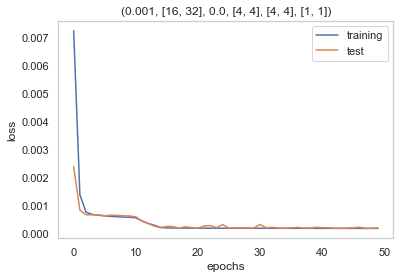

In [116]:
plot(0,train_loss,None,test_loss)

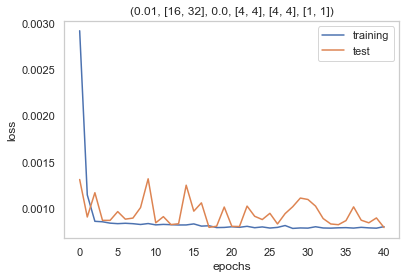

In [106]:
plot(0,train_loss,None,test_loss)

In [52]:
test_set[0:0+batch_size,:,::-1].shape

(64, 288, 2)

In [22]:
batch=torch.Tensor(test_set[0:0+batch_size,:,:].copy()).transpose(1,2)
loss,output=step(batch, batch, model, optimizer, loss_fn, batch_size,True,device)

In [20]:
trim_to=50

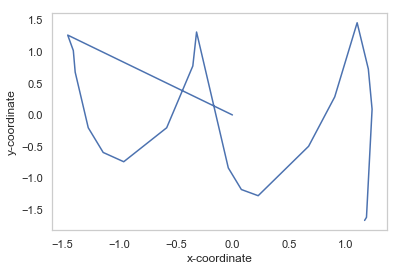

In [26]:
plot_task(test_set[30,:trim_to])

In [76]:
c1=model.encoder[0](batch.to(device))
r1=model.encoder[1](c1)
c2=model.encoder[3](r1)
r2=model.encoder[4](c2)
c3=model.encoder[6](r2)
r3=model.encoder[7](c3)
dc1=model.decoder[0](r3)
dr1=model.decoder[1](dc1)
dc2=model.decoder[3](dr1)
dr2=model.decoder[4](dc2)
dc3=model.decoder[6](dr2)

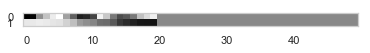

In [79]:
plt.imshow(test_set[30,:trim_to].T,cmap="gray")

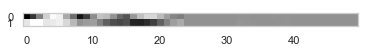

In [91]:
plt.imshow(dc3.detach().cpu().numpy()[30,:,:trim_to],cmap="gray")

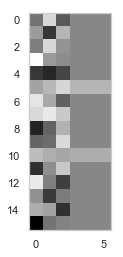

In [82]:
plt.imshow(c1.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

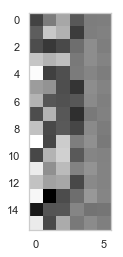

In [90]:
plt.imshow(dc2.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

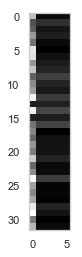

In [86]:
plt.imshow(c2.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

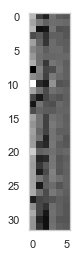

In [89]:
plt.imshow(dc1.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

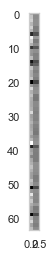

In [88]:
plt.imshow(c3.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

In [36]:
model

CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(2, 16, kernel_size=(8,), stride=(8,))
    (1): ReLU()
    (2): Dropout(p=0.0)
    (3): Conv1d(16, 32, kernel_size=(4,), stride=(4,))
    (4): ReLU()
    (5): Dropout(p=0.0)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(3,))
    (7): ReLU()
    (8): Dropout(p=0.0)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(3,))
    (1): ReLU()
    (2): Dropout(p=0.0)
    (3): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(4,))
    (4): ReLU()
    (5): Dropout(p=0.0)
    (6): ConvTranspose1d(16, 2, kernel_size=(8,), stride=(8,))
  )
)

In [41]:
c1=model.encoder(batch.to(device))

In [31]:
c1.shape

torch.Size([64, 16, 36])

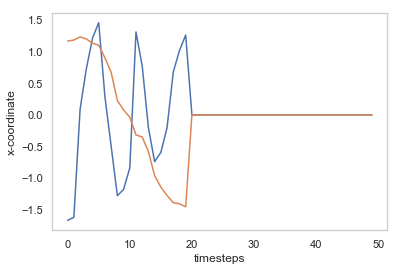

In [44]:
plot_measures(test_set[30,:trim_to],False,(6,4))

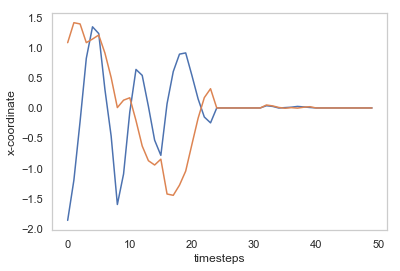

In [28]:
plot_measures(output[30].T[:trim_to],False,(6,4))

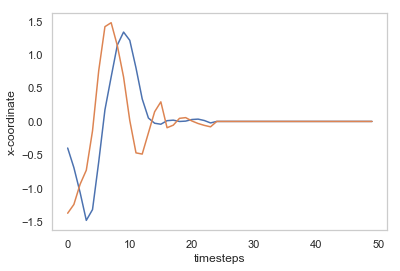

In [89]:
plot_measures(output[i-1].T[:trim_to],False,(6,4))

In [45]:
c1=model.conv1(batch)
r1=model.relu1(c1)

if model.num_layers > 1:
    drop1=model.drop1(r1)
    c2=model.conv2(drop1)
    r2=model.relu2(c2)
    d_drop2=model.d_drop2(r2)
    d_c2=model.d_conv2(d_drop2)
    d_r2=model.d_relu2(d_c2)
    d_drop1=model.d_drop1(d_r2)
else:
    d_drop1=model.d_drop1(r1)

d_c1=model.d_conv1(d_drop1)

AttributeError: 'CNNAutoencoder' object has no attribute 'conv1'

In [96]:
c1.shape

torch.Size([1, 16, 72])

In [99]:
c2.shape

torch.Size([1, 32, 18])

In [97]:
d_c2.shape

torch.Size([1, 16, 72])

In [98]:
d_c1.shape

torch.Size([1, 2, 288])

In [ ]:
p1.shape

In [ ]:
289/17

In [ ]:
model

In [ ]:
plot_task(train_set[0],measure2index)

In [ ]:
289/72

# keep for ref

In [150]:
import torch

class CNNAutoencoder(torch.nn.Module):
    def __init__(self,input_size,hidden_size,conv_kernel,pool_kernel ,padding,
                 stride=1,dilation=1, dropout=0.0):
        super(CNNAutoencoder, self).__init__()

        self.num_layers=len(hidden_size) 
                
        #encoder
        self.conv1=torch.nn.Conv1d(input_size,hidden_size[0],conv_kernel[0],stride=pool_kernel[0],padding=padding[0],dilation=dilation[0])
        self.relu1=torch.nn.ReLU()
        if self.num_layers > 1:
            self.drop1=torch.nn.Dropout(dropout)
            self.conv2=torch.nn.Conv1d(hidden_size[0],hidden_size[1],conv_kernel[1],stride=pool_kernel[1],padding=padding[1],dilation=dilation[1])
            self.relu2=torch.nn.ReLU()
        #self.drop2=torch.nn.Dropout(dropout)
        
        #decoder        
        if self.num_layers > 1:
            self.d_drop2=torch.nn.Dropout(dropout)
            self.d_conv2=torch.nn.ConvTranspose1d(hidden_size[1],hidden_size[0],conv_kernel[1],stride=pool_kernel[1],
                                         padding=padding[1],dilation=dilation[1])
            self.d_relu2=torch.nn.ReLU()
        self.d_drop1=torch.nn.Dropout(dropout)
        self.d_conv1=torch.nn.ConvTranspose1d(hidden_size[0],input_size,conv_kernel[0],stride=pool_kernel[0],
                                     padding=padding[0],dilation=dilation[0])
        #self.sigmoid=torch.nn.Sigmoid()
        
    def forward(self,subject):
        c1=self.conv1(subject)
        r1=self.relu1(c1)

        if self.num_layers > 1:
            drop1=self.drop1(r1)
            c2=self.conv2(drop1)
            r2=self.relu2(c2)
            d_drop2=self.d_drop2(r2)
            d_c2=self.d_conv2(d_drop2)
            d_r2=self.d_relu2(d_c2)
            d_drop1=self.d_drop1(d_r2)
        else:
            d_drop1=self.d_drop1(r1)
            
        d_c1=self.d_conv1(d_drop1)
        
        return d_c1#self.sigmoid(d_c1)


13.92721099123634

In [ ]:
import torch

class CNNAutoencoder(torch.nn.Module):
    def __init__(self,input_size,hidden_size,conv_kernel,pool_kernel ,padding,
                 stride=1,dilation=1, dropout=0.0):
        super(CNNAutoencoder, self).__init__()

        self.num_layers=len(hidden_size) 
        
        #encoder
        self.conv1=torch.nn.utils.weight_norm(
            torch.nn.Conv1d(input_size,hidden_size[0],conv_kernel[0],stride=1,padding=padding[0],dilation=dilation[0]))
        self.relu1=torch.nn.ReLU()
        self.pool1=torch.nn.MaxPool1d(pool_kernel[0],pool_kernel[0],padding=0,dilation=1)
        if self.num_layers > 1:
            self.drop1=torch.nn.Dropout(dropout)
            self.conv2=torch.nn.utils.weight_norm(
                torch.nn.Conv1d(hidden_size[0],hidden_size[1],conv_kernel[1],stride=1,padding=padding[1],dilation=dilation[1]))
            self.relu2=torch.nn.ReLU()
            self.pool2=torch.nn.MaxPool1d(pool_kernel[1],pool_kernel[1],padding=0,dilation=1)
        self.drop2=torch.nn.Dropout(dropout)
        
        #decoder        
        if self.num_layers > 1:
            self.d_drop2=torch.nn.Dropout(dropout)
            self.d_conv2=torch.nn.utils.weight_norm(
                torch.nn.ConvTranspose1d(hidden_size[1],hidden_size[0],conv_kernel[1],stride=pool_kernel[1],
                                         padding=padding[1],dilation=dilation[1],output_padding=pool_kernel[1]-1))
            self.d_relu2=torch.nn.ReLU()
        self.d_drop1=torch.nn.Dropout(dropout)
        self.d_conv1=torch.nn.utils.weight_norm(
            torch.nn.ConvTranspose1d(hidden_size[0],input_size,conv_kernel[0],stride=pool_kernel[0],
                                     padding=padding[0],dilation=dilation[0],output_padding=pool_kernel[0]-1))
        #self.sigmoid=torch.nn.Sigmoid()
        
    def forward(self,subject):
        c1=self.conv1(subject)
        r1=self.relu1(c1)
        p1=self.pool1(r1)

        if self.num_layers > 1:
            drop1=self.drop1(p1)
            c2=self.conv2(drop1)
            r2=self.relu2(c2)
            p2=self.pool2(r2)
            drop2=self.drop2(p2)
            d_c2=self.d_conv2(drop2)
            d_r2=self.d_relu2(d_c2)
            d_drop2=self.d_drop2(d_r2)
        else:
            d_drop2=self.drop2(p1)
            
        d_c1=self.d_conv1(d_drop2)
        
        return d_c1#self.sigmoid(d_c1)


In [ ]:
c1=model.conv1(subject)
r1=model.relu1(c1)
p1=model.pool1(r1)

if model.num_layers > 1:
    drop1=model.drop1(p1)
    c2=model.conv2(drop1)
    r2=model.relu2(c2)
    p2=model.pool2(r2)
    drop2=model.drop2(p2)
    d_c2=model.d_conv2(drop2)
    d_r2=model.d_relu2(d_c2)
    d_drop2=model.d_drop2(d_r2)
else:
    d_drop2=model.drop2(p1)

d_c1=model.d_conv1(d_drop2)